In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test

#### Get the relevant training datasets and combine them to form the full training set with Proteins and Peptides

In [2]:
train_proteins_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')
#print(train_proteins_df.shape)
#print(train_proteins_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
#train_proteins_df.head(10)

train_peptides_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
#print(train_peptides_df.shape)
#print(train_peptides_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
#train_peptides_df.head(10)

pro_pep_join = pd.merge(train_proteins_df, train_peptides_df, on=['patient_id','visit_id','visit_month','UniProt'], how='inner')

del train_proteins_df, train_peptides_df
gc.collect()

train_clinical_data_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
#print(train_clinical_data_df.shape)
#print(train_clinical_data_df.memory_usage(deep=True).sum()/1024/1024, " MBs")

full_training_data = pd.merge(pro_pep_join, train_clinical_data_df, on=['patient_id','visit_id','visit_month'], how='inner')

del pro_pep_join, train_clinical_data_df
gc.collect()

full_training_data = full_training_data.drop(columns=['UniProt','Peptide','upd23b_clinical_state_on_medication','patient_id'])

#print(full_training_data.shape)
#full_training_data.head(10)

#### Remove the NaNs from the UPDRS test scores, using the mean from within the same group of UPDRS test scores, e.g. NaNs in updrs_4 are filled with mean of updrs_4

In [3]:
full_training_data_melted = full_training_data.melt(id_vars=['visit_id','visit_month','NPX','PeptideAbundance']
                                                    , value_vars=['updrs_1','updrs_2','updrs_3','updrs_4'],var_name='updrs_test', value_name='updrs_test_score')

list_of_updrs_tests = full_training_data_melted.updrs_test.unique()

temp_df = full_training_data_melted.groupby(['updrs_test']).agg(visit_month_per_patient=('visit_id', 'count')
                                                      , mean_updrs_test_score=('updrs_test_score', 'mean') ).reset_index(level=['updrs_test'])

for i in range(len(list_of_updrs_tests)):
    #print(list_of_updrs_tests[i])
    updrs_test_mean = full_training_data[list_of_updrs_tests[i]].mean()
    #print(updrs_test_mean)
    full_training_data.fillna({list_of_updrs_tests[i]:updrs_test_mean}, inplace=True)

#### Combine all UPDRS scores are one column and creating categorical column of UPDRS tests

In [4]:
full_training_data_melted = full_training_data.melt(id_vars=['visit_id','visit_month','NPX','PeptideAbundance']
                                                    , value_vars=['updrs_1','updrs_2','updrs_3','updrs_4'],var_name='updrs_test', value_name='updrs_test_score')

#print(full_training_data_melted.updrs_test_score.unique())
#print(full_training_data_melted.visit_month.unique())

#full_training_data_melted[full_training_data_melted['visit_id']=='55_0']

#### Check for NaNs

In [ ]:
full_training_data_melted.isna().sum()

#### Proceed to create a train-test split on the Training dataset, to test out the accuracy of the developed models

In [ ]:
#full_training_data_melted[['updrs_test_score','PeptideAbundance','NPX','group_key']].corr()
full_training_data_melted['updrs_test_score'].hist()

<AxesSubplot:>

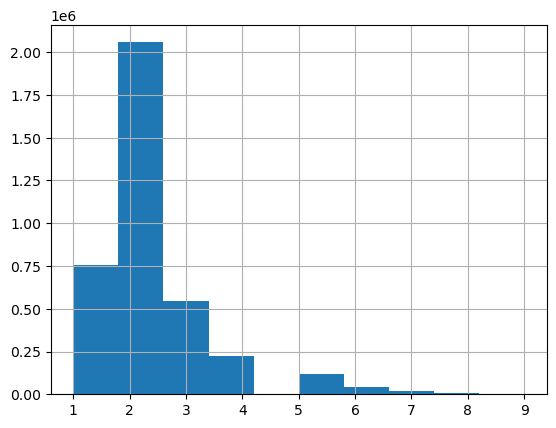

In [5]:
full_training_data_melted['updrs_score_category'] = pd.cut(full_training_data_melted['updrs_test_score'],
                                                          bins=[-np.inf, 0., 10., 20., 30., 40., 50., 60., 70., 80., np.inf],
                                                          labels=[1,2,3,4,5,6,7,8,9,10])

full_training_data_melted['updrs_score_category'].hist()

#### Check if there are any NaNs in the created bins, there shouldn't be any

In [ ]:
full_training_data_melted['updrs_score_category'].unique()
#full_training_data_melted[full_training_data_melted['updrs_score_category'].isna()]
#full_training_data_melted[full_training_data_melted['updrs_test_score'] < 0]

In [6]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(full_training_data_melted, full_training_data_melted['updrs_score_category']):
    strat_train_set = full_training_data_melted.loc[train_index]
    strat_test_set = full_training_data_melted.loc[test_index]

#### Now, let's verify the percentage distribution of the data in the train and test splits, they should be very close

In [ ]:
strat_test_set['updrs_score_category'].value_counts()/len(strat_test_set)

In [ ]:
strat_train_set['updrs_score_category'].value_counts()/len(strat_train_set)

#### Get rid of the unwanted column which was created to assist in the splitting process

In [7]:
strat_train_set = strat_train_set.drop(columns=['updrs_score_category'])
strat_test_set = strat_test_set.drop(columns=['updrs_score_category'])
#strat_train_set.head(10)

#### Now let us separate the labels and numeric, categorical attributes so that we can build the scikit learn pipelines

In [8]:
strat_train_set_wo_labels = strat_train_set.drop('updrs_test_score', axis=1)
strat_train_set_labels = strat_train_set['updrs_test_score'].copy()
strat_train_set_numeric = strat_train_set_wo_labels.drop(columns=['visit_id','visit_month','updrs_test'])
strat_train_set_cat = strat_train_set_wo_labels[['visit_month','updrs_test']]

strat_test_set_wo_labels = strat_test_set.drop('updrs_test_score', axis=1)
strat_test_set_labels = strat_test_set['updrs_test_score'].copy()

del full_training_data, full_training_data_melted
gc.collect()

84

In [9]:
numeric_pipeline = Pipeline([
    ('standard_scaler', StandardScaler())
])

numeric_attributes = list(strat_train_set_numeric)
categorical_attributes = list(strat_train_set_cat)

full_pipeline = ColumnTransformer([
    ('num', numeric_pipeline, numeric_attributes),
    ('cat', OneHotEncoder(), categorical_attributes)
])

strat_train_set_prepared = full_pipeline.fit_transform(strat_train_set_wo_labels)
strat_test_set_prepared = full_pipeline.fit_transform(strat_test_set_wo_labels)

#### Train the Linear Regression model

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg_model = lin_reg.fit(strat_train_set_prepared, strat_train_set_labels)

### Testing the RMSE
#### RMSE <= 0.75 : Very good accuracy | 0.75 < RMSE <= 1.0 : Good accuracy

#### First on train data (train split from the full training dataset)

In [ ]:
train_df_predictions = lin_reg_model.predict(strat_train_set_prepared)
mse = mean_squared_error(strat_train_set_labels, train_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

#### 2nd on test data (test split from the full training dataset)

In [ ]:
test_df_predictions = lin_reg_model.predict(strat_test_set_prepared)
mse = mean_squared_error(strat_test_set_labels, test_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

In [82]:
def get_predictions(df, df_proteins, df_peptides, model, sklearn_pipeline):
    pro_pep_join = pd.merge(df_proteins, df_peptides, on=['patient_id','visit_id','visit_month','UniProt'], how='inner')
    del df_proteins, df_peptides
    gc.collect()
    full_df = pd.merge(pro_pep_join, df, on=['patient_id','visit_id','visit_month'], how='inner')
    #print(full_df.head(10))
    
    #full_df = full_df.drop(columns=['UniProt','Peptide','patient_id','group_key_x','group_key_y','group_key','row_id'])
    full_df = full_df[['visit_id','visit_month','NPX','PeptideAbundance','updrs_test']]
    full_df = full_df.drop_duplicates()
    #print(full_df.shape)
    #print(full_df.visit_id.nunique)

    df_prepared = sklearn_pipeline.transform(full_df)
    
    result = pd.DataFrame()
    temp_outer = full_df[['visit_id','visit_month','updrs_test']]
    temp_outer['rating'] = pd.DataFrame(lin_reg_model.predict(df_prepared),columns=['rating']).round(decimals=0)
    #print(temp_outer.shape)

    for m in [0, 6, 12, 24]:
        print('m is ', str(m))
        temp = temp_outer[temp_outer['visit_month']==m]
        print(temp.shape)
        temp["prediction_id"] = temp["visit_id"] + '_' + temp['updrs_test'] + "_plus_" + str(m) + "_months"
        temp = temp [['prediction_id', 'rating']]
        result = result.append(temp)
        #print(result.shape)

    result = result.fillna(0)
    #print(result.shape)
    result = result.drop_duplicates(subset=['prediction_id', 'rating'], keep='first')
    print(result.shape)
    return result

In [97]:
df_proteins = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv')
print(df_proteins.shape)
#print(train_proteins_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
#train_proteins_df.head(10)

df_peptides = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv')
print(df_peptides.shape)
#print(train_peptides_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
#train_peptides_df.head(10)

df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test.csv')
print(df.shape)
#print(train_clinical_data_df.memory_usage(deep=True).sum()/1024/1024, " MBs")

pro_pep_join = pd.merge(df_proteins, df_peptides, on=['patient_id','visit_id','visit_month','UniProt'], how='inner')
del df_proteins, df_peptides
gc.collect()
full_df = pd.merge(pro_pep_join, df, on=['patient_id','visit_id','visit_month'], how='inner')
full_df = full_df[['patient_id','visit_id','visit_month','NPX','PeptideAbundance','updrs_test']]
print(full_df.shape)

full_df.head(10)
#result = get_predictions(df, df_proteins, df_peptides, lin_reg_model, full_pipeline)

(453, 6)
(2057, 7)
(16, 6)
(8228, 6)


,patient_id,visit_id,visit_month,NPX,PeptideAbundance,updrs_test
0,50423,50423_0,0,33127.9,22226.3,updrs_1
1,50423,50423_0,0,33127.9,22226.3,updrs_2
2,50423,50423_0,0,33127.9,22226.3,updrs_3
3,50423,50423_0,0,33127.9,22226.3,updrs_4
4,50423,50423_0,0,33127.9,10901.6,updrs_1
5,50423,50423_0,0,33127.9,10901.6,updrs_2
6,50423,50423_0,0,33127.9,10901.6,updrs_3
7,50423,50423_0,0,33127.9,10901.6,updrs_4
8,50423,50423_0,0,490742.0,51499.4,updrs_1
9,50423,50423_0,0,490742.0,51499.4,updrs_2


In [ ]:
"""for mon in [0,6,12,24]:
    for test in ['updrs_1','updrs_2','updrs_3','updrs_4']:
"""        

In [94]:
full_df.patient_id.unique()

array([50423,  3342])

In [ ]:
#full_df = full_df.drop(columns=['UniProt','Peptide','patient_id','group_key_x','group_key_y','group_key','row_id'])
full_df = full_df[['visit_id','visit_month','NPX','PeptideAbundance','updrs_test']]
full_df = full_df.drop_duplicates()
#print(full_df.shape)
#print(full_df.visit_id.nunique)

df_prepared = full_pipeline.transform(full_df)

result = pd.DataFrame()
temp_outer = full_df[['visit_id','visit_month','updrs_test']]
temp_outer['rating'] = pd.DataFrame(lin_reg_model.predict(df_prepared),columns=['rating']).round(decimals=0)

In [84]:
result

,prediction_id,rating
0,50423_0_updrs_1_plus_0_months,5.0
1,50423_0_updrs_2_plus_0_months,4.0
2,50423_0_updrs_3_plus_0_months,15.0
3,50423_0_updrs_4_plus_0_months,0.0
4084,3342_6_updrs_1_plus_6_months,9.0
4085,3342_6_updrs_2_plus_6_months,8.0
4086,3342_6_updrs_3_plus_6_months,19.0
4087,3342_6_updrs_4_plus_6_months,4.0


In [78]:
"""import amp_pd_peptide
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()

for (test, test_peptides, test_proteins, submission) in iter_test:
    result = get_predictions(test, test_proteins, test_peptides, lin_reg_model, full_pipeline)
    env.predict(result)"""
    
##result.to_csv('/kaggle/working/submission.csv', header=True, index=False)